# Protocol to set a location
1. The first location to have a direct match (distance == 0) in this order: Ventricles => GM => Dorsal => Cerebellum => Thalamus => Brainstem => WM
2. If no direct match, the lowest distance lower than 3 gets the match.
3. If there is no distance lower than 3, it is considered WM lesion.

In [3]:
from tqdm import tqdm
import pandas as pd
import nibabel as nib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from config import *
from utils import get_dataframe_from_metadata
from analysis import load_results, compute_lw_model_results, compute_metrics

Loading configuration...
Configuration loaded successfully!
_____________________________



In [4]:
WHERE_TO_SAVE = "/Users/german/Desktop/figs_location_analysis_FS"
if not os.path.exists(WHERE_TO_SAVE):
    os.makedirs(WHERE_TO_SAVE)

MODEL_NAME = "binet_phase_flair"
#MODEL_NAME = "monomodal_phase"
FOLD_VERSION = "all"
ENSEMBLED = False
FPR = 0.05

In [5]:

lw_results = load_results()
#lw_results = lw_results.loc[lw_results["unseen"]]
#lw_results = lw_results.loc[(lw_results["model_name"] == MODEL_NAME) & (lw_results["evaluation"] == FOLD_VERSION) & (lw_results["ensembled"] == ENSEMBLED) & (lw_results["unseen"])]
lw_th_results, lw_th_per_fold, lw_th_per_model = compute_lw_model_results(lw_results, FPR)
lw_th_results = lw_th_results[(lw_th_results["unseen"] == 1) & (lw_th_results["evaluation"] == FOLD_VERSION)]

loc_df = get_dataframe_from_metadata()
loc_df = loc_df[~loc_df["location"].isna()]
# EXCLUDE
loc_df = loc_df.drop(loc_df[(loc_df.patient == 13) | (loc_df.patient == 39) | (loc_df.patient == 78) | (loc_df.patient == 45) | (loc_df.patient == 84)].index)
df = pd.merge(lw_th_results, loc_df, how='inner', on=['dataset', 'patient', 'lesion'])
loc_df = pd.merge(loc_df, lw_results[["dataset", "patient", "lesion"]].drop_duplicates(), how="inner", on=["dataset", "patient", "lesion"])

res_per_loc = pd.DataFrame(data = [(name, eva, ens, loc, ) + compute_metrics(grouped["truth"], grouped["pred"]) for (name, eva, ens, loc), grouped in df.groupby(["model_name", "evaluation", "ensembled", "location"])], columns=("model_name", "evaluation", "ensembled", "location", "tn", "fp", "fn", "tp", "acc", "f1", "tpr", "fpr", "ppv", "npv"))


45 models available.


/Users/german/msrims/testing/analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_by_fold["pred_th"] = 0
/Users/german/miniconda3/envs/msrims/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/german/msrims/testing/analysis.py:65: RuntimeWarning: invalid value encountered in long_scalars
  tpr = tp / (fn + tp) # sensitivity
/Users/german/msrims/testing/analysis.py:66: RuntimeWarning: invalid value encountered in lon

In [6]:
np.unique(res_per_loc["location"])

array(['BrainStem', 'Cerebellum', 'Deep GM', 'GM', 'Periventricular',
       'WM'], dtype=object)

In [7]:
loc_df

,dataset,patient,lesion,rim,volume,ignore,main_reason,reasons,location
0,0,56,2000,False,146,False,NaN,,WM
1,0,56,2001,False,252,False,NaN,,Periventricular
2,0,56,2002,False,132,False,NaN,,Periventricular
3,0,56,2003,False,206,False,NaN,,Periventricular
4,0,56,2004,False,100,False,NaN,,Periventricular
...,...,...,...,...,...,...,...,...,...
4989,1,55,2014,False,80,False,NaN,,WM
4990,1,55,2015,False,50,False,NaN,,Periventricular
4991,1,55,2016,False,67,False,NaN,,Periventricular
4992,1,55,2018,False,50,False,NaN,,WM


In [8]:
res_per_loc[res_per_loc["location"] == "Ventricles"].sort_values("acc", ascending=False)

,model_name,evaluation,ensembled,location,tn,fp,fn,tp,acc,f1,tpr,fpr,ppv,npv


In [9]:
res_per_loc[res_per_loc["model_name"] == MODEL_NAME]

,model_name,evaluation,ensembled,location,tn,fp,fn,tp,acc,f1,tpr,fpr,ppv,npv
18,binet_phase_flair,all,False,BrainStem,103,0,0,0,1.000000,NaN,NaN,0.000000,NaN,1.000000
19,binet_phase_flair,all,False,Cerebellum,59,1,0,0,0.983333,NaN,NaN,0.016667,0.000000,1.000000
20,binet_phase_flair,all,False,Deep GM,43,0,0,0,1.000000,NaN,NaN,0.000000,NaN,1.000000
21,binet_phase_flair,all,False,GM,928,53,22,43,0.928298,0.534161,0.661538,0.054027,0.447917,0.976842
22,binet_phase_flair,all,False,Periventricular,1100,103,59,166,0.886555,0.672065,0.737778,0.085619,0.617100,0.949094
23,binet_phase_flair,all,False,WM,2162,53,32,67,0.963267,0.611872,0.676768,0.023928,0.558333,0.985415


In [10]:

loc_df = pd.merge(loc_df, lw_results[["dataset", "patient", "lesion"]].drop_duplicates(), how="inner", on=["dataset", "patient", "lesion"])
lw_results[lw_results["patient"] == 47].drop_duplicates(["dataset", "patient", "lesion"])

,model_name,evaluation,ensembled,fold,dataset,patient,lesion,unseen,truth,pred
18908,bimodal_phase_flair,all,False,0,1,47,1000,0,1,0.999969
18912,bimodal_phase_flair,all,False,0,1,47,1001,0,1,0.914769
18916,bimodal_phase_flair,all,False,0,1,47,1002,0,1,0.992623
18920,bimodal_phase_flair,all,False,0,1,47,1003,0,1,0.999954
18924,bimodal_phase_flair,all,False,0,1,47,2000,0,0,0.016735
...,...,...,...,...,...,...,...,...,...,...
19300,bimodal_phase_flair,all,False,0,1,47,2111,0,0,0.000476
19304,bimodal_phase_flair,all,False,0,1,47,2114,0,0,0.258132
19308,bimodal_phase_flair,all,False,0,1,47,2115,0,0,0.000087
19312,bimodal_phase_flair,all,False,0,1,47,2116,0,0,0.007786


In [15]:
count_per_loc = pd.DataFrame(data = [(loc if len(grouped.index) > 120 else "Others", len(grouped.loc[grouped["rim"]].index), len(grouped.loc[~grouped["rim"]].index)) for loc, grouped in loc_df.groupby("location")], columns=["location", "rim+", "rim-"])

count_per_loc['rim+'] = count_per_loc.groupby(['location'])['rim+'].transform('sum')
count_per_loc['rim-'] = count_per_loc.groupby(['location'])['rim-'].transform('sum')
count_per_loc = count_per_loc.drop_duplicates()

count_per_loc["total"] = count_per_loc["rim+"] + count_per_loc["rim-"]
count_per_loc = count_per_loc.sort_values("total", ascending=True)
count_per_loc

,location,rim+,rim-,total
2,Deep GM,0,43,43
1,Cerebellum,0,60,60
0,BrainStem,0,103,103
3,GM,65,981,1046
4,Periventricular,225,1203,1428
5,WM,99,2215,2314


In [17]:
count_per_loc.sum()

location    Deep GMCerebellumBrainStemGMPeriventricularWM
rim+                                                  389
rim-                                                 4605
total                                                4994
dtype: object

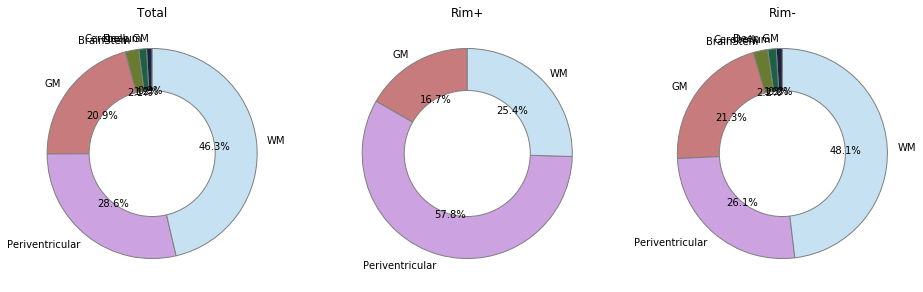

In [16]:

labels = count_per_loc["location"]
colors = sns.color_palette("cubehelix", len(labels))

def plot_pie(title, ax, data, labels, colors):
    data, labels, colors = zip(*[(val, lab, col) for (val, lab, col) in zip(data, labels, colors) if val != 0])
    ax.pie(data, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90,
          wedgeprops = {'linewidth': 1, 'edgecolor': 'gray'}, colors=colors)
    ax.set_title(title)
    #draw circle
    centre_circle = plt.Circle((0,0),0.6,fc='white', edgecolor='gray')
    ax.add_artist(centre_circle)
    
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

plot_pie(f"Total", ax[0], list(count_per_loc["total"]), labels, colors)
plot_pie(f"Rim+", ax[1], list(count_per_loc["rim+"]), labels, colors)
plot_pie(f"Rim-", ax[2], list(count_per_loc["rim-"]), labels, colors)

plt.savefig(os.path.join(WHERE_TO_SAVE, 'pies_distribution_per_location.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

In [14]:
count_per_loc.sum()

location    OthersGMPeriventricularWM
rim+                              389
rim-                             4605
total                            4994
dtype: object

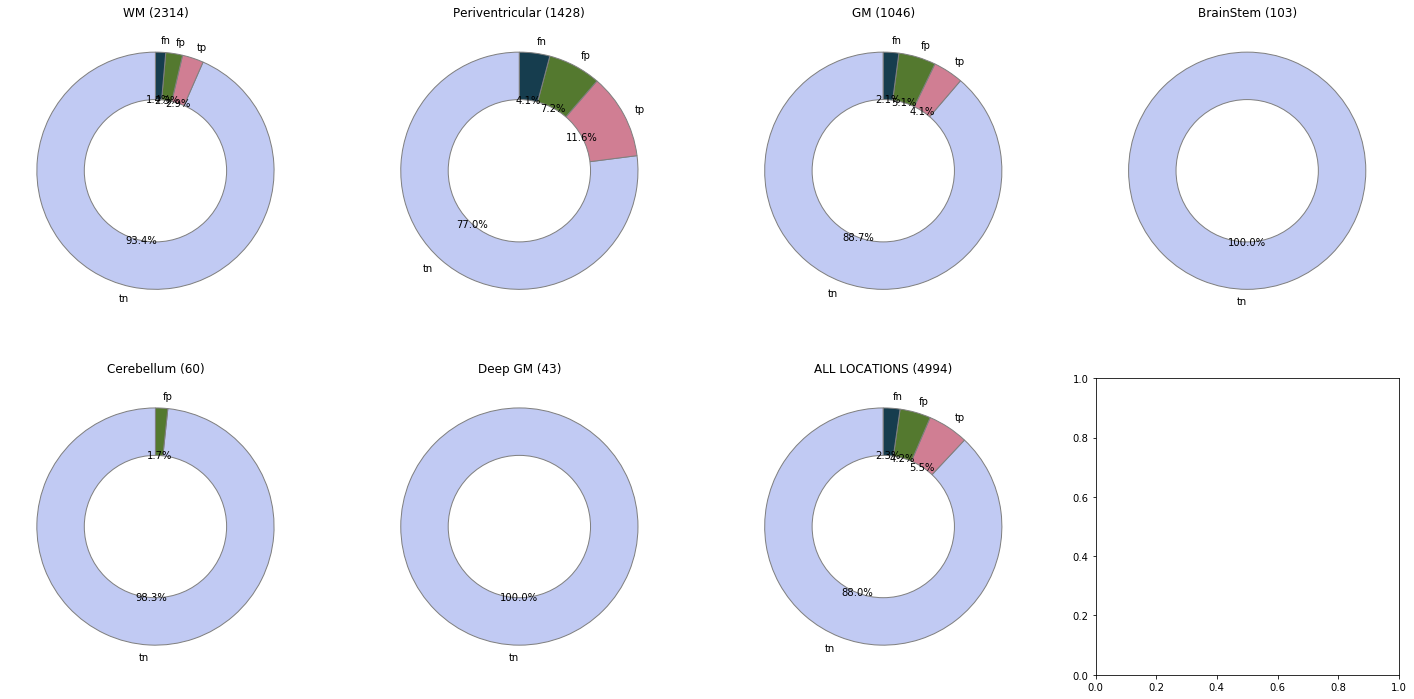

In [15]:
our_model_results = res_per_loc[res_per_loc["model_name"] == MODEL_NAME].sort_values("tn", ascending=False)

locations = list(our_model_results["location"].drop_duplicates())

labels = ["tn", "tp", "fp", "fn"]
colors = list(sns.color_palette("cubehelix", len(labels)))
colors.reverse()
    
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
for i in range(len(locations)):
    plot_pie(f"{locations[i]} ({our_model_results[labels].iloc[i].sum()})", ax[i // 4][i % 4], list(our_model_results[labels].iloc[i]), labels, colors)
    
i += 1
plot_pie(f"ALL LOCATIONS ({our_model_results.sum()[labels].sum()})", ax[i // 4][i % 4], list(our_model_results.sum()[labels]), labels, colors)

#plt.savefig(os.path.join(WHERE_TO_SAVE, f'pies_errors_per_location_{MODEL_NAME}.pdf'), dpi = 400, format='pdf', bbox_inches='tight')#

In [ ]:
our_model_results = res_per_loc[res_per_loc["model_name"] == MODEL_NAME].sort_values("tn", ascending=False)

locations = list(our_model_results["location"].drop_duplicates())

labels = ["tn", "tp", "fp", "fn"]
colors = list(sns.color_palette("cubehelix", len(labels)))
colors.reverse()
    
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
for i in range(len(locations)):
    plot_pie(f"{locations[i]} ({our_model_results[labels].iloc[i].sum()})", ax[i // 4][i % 4], list(our_model_results[labels].iloc[i]), labels, colors)
    
i += 1
plot_pie(f"ALL LOCATIONS ({our_model_results.sum()[labels].sum()})", ax[i // 4][i % 4], list(our_model_results.sum()[labels]), labels, colors)

plt.savefig(os.path.join(WHERE_TO_SAVE, f'pies_errors_per_location_{MODEL_NAME}.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

In [23]:
res_to_show[res_to_show["model_name"] == "binet_phase_flair"].sort_values("acc")

,model_name,evaluation,ensembled,location,tn,fp,fn,tp,acc,f1,tpr,fpr,ppv,npv
22,binet_phase_flair,all,False,Periventricular,1100,103,59,166,0.886555,0.672065,0.737778,0.085619,0.617100,0.949094
21,binet_phase_flair,all,False,GM,928,53,22,43,0.928298,0.534161,0.661538,0.054027,0.447917,0.976842
23,binet_phase_flair,all,False,WM,2162,53,32,67,0.963267,0.611872,0.676768,0.023928,0.558333,0.985415
19,binet_phase_flair,all,False,Cerebellum,59,1,0,0,0.983333,NaN,NaN,0.016667,0.000000,1.000000
18,binet_phase_flair,all,False,BrainStem,103,0,0,0,1.000000,NaN,NaN,0.000000,NaN,1.000000
20,binet_phase_flair,all,False,Deep GM,43,0,0,0,1.000000,NaN,NaN,0.000000,NaN,1.000000


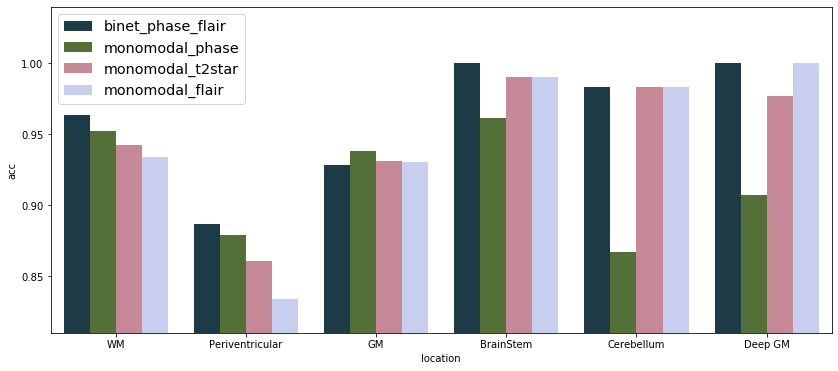

In [20]:
count_per_loc = pd.DataFrame(data = [(loc, len(grouped.loc[grouped["rim"]].index), len(grouped.loc[~grouped["rim"]].index)) for loc, grouped in loc_df.groupby("location")], columns=["location", "rim+", "rim-"])
count_per_loc["total"] = count_per_loc["rim+"] + count_per_loc["rim-"]

to_show = ["binet_phase_flair", "monomodal_phase", "monomodal_t2star", "monomodal_flair"]
res_to_show = res_per_loc.loc[res_per_loc["model_name"].isin(to_show)]

plt.figure(figsize=(14, 6))
sns.barplot(data=res_to_show, hue="model_name", y="acc", x="location", hue_order=to_show, order=count_per_loc.sort_values("total", ascending=False)["location"], palette=sns.color_palette("cubehelix", len(to_show)))
plt.ylim((0.81,1.04))
plt.legend(fontsize="x-large")
plt.savefig(os.path.join(WHERE_TO_SAVE, 'barplots_performance_per_location_ACC.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

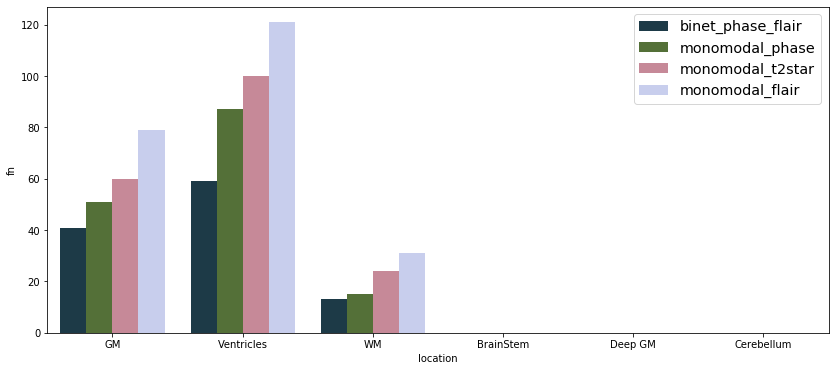

In [29]:
count_per_loc = pd.DataFrame(data = [(loc, len(grouped.loc[grouped["rim"]].index), len(grouped.loc[~grouped["rim"]].index)) for loc, grouped in loc_df.groupby("location")], columns=["location", "rim+", "rim-"])
count_per_loc["total"] = count_per_loc["rim+"] + count_per_loc["rim-"]

to_show = ["binet_phase_flair", "monomodal_phase", "monomodal_t2star", "monomodal_flair"]
res_to_show = res_per_loc.loc[res_per_loc["model_name"].isin(to_show)]

plt.figure(figsize=(14, 6))
sns.barplot(data=res_to_show, hue="model_name", y="fn", x="location", hue_order=to_show, order=count_per_loc.sort_values("total", ascending=False)["location"], palette=sns.color_palette("cubehelix", len(to_show)))
#plt.ylim((0.81,1.04))
plt.legend(fontsize="x-large")
plt.savefig(os.path.join(WHERE_TO_SAVE, 'barplots_performance_per_location_FN.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

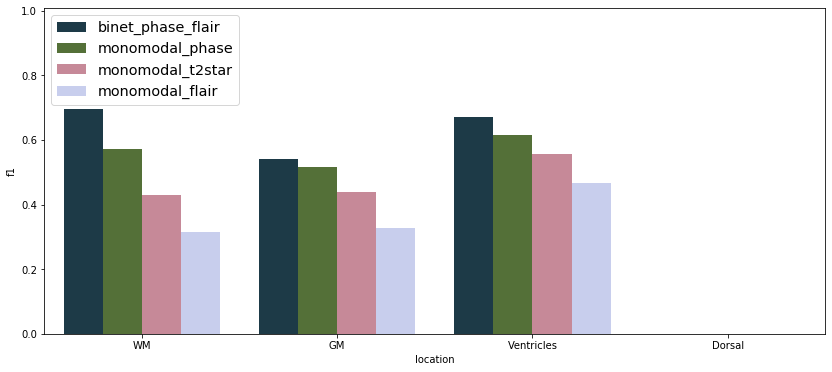

In [30]:
locations_to_show = ["WM", "GM", "Ventricles", "Dorsal"]
plt.figure(figsize=(14, 6))
sns.barplot(data=res_to_show, hue="model_name", y="f1", x="location", hue_order=to_show, order=locations_to_show, palette=sns.color_palette("cubehelix", len(to_show)))
plt.legend(fontsize="x-large")
plt.ylim((0,1.01))
plt.savefig(os.path.join(WHERE_TO_SAVE, 'barplots_performance_per_location_F1.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

In [19]:
lw_results

,model_name,evaluation,ensembled,fold,dataset,patient,lesion,unseen,truth,pred
0,bimodal_phase_flair,all,False,0,0,56,2000,0,0,0.021313
1,bimodal_phase_flair,all,False,1,0,56,2000,0,0,0.143120
2,bimodal_phase_flair,all,False,2,0,56,2000,0,0,0.005009
3,bimodal_phase_flair,all,False,3,0,56,2000,1,0,0.030391
4,bimodal_phase_flair,all,False,0,0,56,2001,0,0,0.922694
...,...,...,...,...,...,...,...,...,...,...
2192,mono_t2star_basel,chuv,True,0,1,55,2014,1,0,0.444926
2193,mono_t2star_basel,chuv,True,0,1,55,2015,1,0,0.672084
2194,mono_t2star_basel,chuv,True,0,1,55,2016,1,0,0.446431
2195,mono_t2star_basel,chuv,True,0,1,55,2018,1,0,0.932096
